[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MSIA/msia432-meme-generation-project/blob/main/notebooks/03_basic_model_modify.ipynb)

## Setup

In [1]:
# !rm -r data
# !rm -r msia432-meme-generation-project
# !rm -r checkpoints

In [2]:
#!pip install fastprogress

In [3]:
import collections
import random
import os
from pathlib import Path
import time
import json
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
from fastprogress.fastprogress import progress_bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
data_path = Path('../data')

In [5]:
random.seed(10)

In [6]:
# Adapted from: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    in_colab = True
except Exception:
    in_colab = False

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Training can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print('NUM GPUS:', len(tf.config.list_physical_devices('GPU')))

NUM GPUS: 1


## Model Configuration

In [7]:
subset = True
subset_size = 100_000

# Choose how many words from the vocabulary, default to 5000
top_k = 6000

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Image ReSize Target 
img_size = (299, 299)

# Which model to use for encoder 
model_name = 'resnet50'

# Calculate bleu score for how many sentences in the validation set, default 200 (None means whole validation set)
bleu_num = 1000

# whether to save checkpoint
save = False

In [8]:
def assign_model(image_model):
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    return keras.Model(new_input, hidden_layer)

In [9]:
if model_name == 'resnet50':
    preprocess_func = keras.applications.resnet.preprocess_input
    
    image_model = keras.applications.ResNet50(include_top=False, weights='imagenet')
    image_features_extract_model = assign_model(image_model)

elif model_name == 'inception_v3':
    preprocess_func = keras.applications.inception_v3.preprocess_input
    image_model = keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
    image_features_extract_model = assign_model(image_model)

elif model_name == 'InceptionResNetV2':
    preprocess_func = keras.applications.inception_resnet_v2.preprocess_input
    image_model = keras.applications.InceptionResNetV2(include_top=False,
                                                       weights='imagenet')
    image_features_extract_model = assign_model(image_model)    

elif model_name == 'EfficientNetB1':
    preprocess_func = keras.applications.efficientnet.preprocess_input
    image_model = keras.applications.EfficientNetB1(include_top=False,
                                                    weights='imagenet')
    image_features_extract_model = assign_model(image_model)

## Load Data

In [10]:
if in_colab and not os.path.exists('data'):
  !git clone https://github.com/MSIA/msia432-meme-generation-project.git
  !mv msia432-meme-generation-project/data .
  df_match = pd.read_csv('data/data_match.csv')
elif not in_colab:
  df_match = pd.read_csv(data_path / 'data_match.csv')
elif in_colab and os.path.exists('data'):
  df_match = pd.read_csv('data/data_match.csv')
else:
  print('check your data path!')

In [11]:
df_match['image_path'] = df_match['image_path'].str.replace('\../', '')

In [12]:
df_match.head(2)

,label,text,impute_image_name,real_image_name,image_path
0,y-u-no,<start> meme generator users y u no give me mo...,y-u-no.jpg,y-u-no.jpg,data/memes/y-u-no.jpg
1,y-u-no,<start> steve jobs y u no respawn?! <end>,y-u-no.jpg,y-u-no.jpg,data/memes/y-u-no.jpg


In [13]:
train_captions = list(df_match['text'].values)
img_name_vector = list(df_match['image_path'].values)

In [14]:
len(train_captions), len(img_name_vector)

(409831, 409831)

In [15]:
train_captions[0:2]

['<start> meme generator users y u no give me more upvotes? <end>',
 '<start> steve jobs y u no respawn?! <end>']

In [16]:
img_name_vector[0:2]

['data/memes/y-u-no.jpg', 'data/memes/y-u-no.jpg']

#### Optional: use a subset

In [17]:
if subset:
  train_captions = train_captions[:subset_size]
  img_name_vector = img_name_vector[:subset_size]
  assert (len(train_captions), len(img_name_vector)) == (subset_size, subset_size)

### Show the image

<start> meme generator users y u no give me more upvotes? <end>


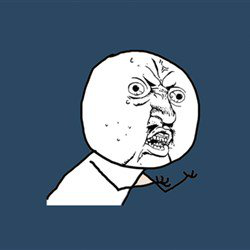

In [18]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess

### Preprocess the images using ResetNet50

In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = preprocess_func(img)
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


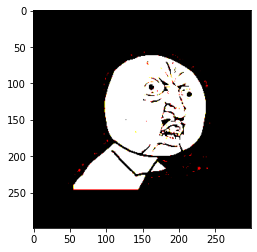

In [20]:
plt.imshow(load_image(img_name_vector[0])[0])

In [21]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in  progress_bar(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [22]:
# Shape of the vector extracted from the pretrained model
attention_features_shape, features_shape = tuple(batch_features.shape[1:3])

In [23]:
attention_features_shape, features_shape

(100, 2048)

### Preprocess and tokenize the captions

In [24]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [25]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=top_k,
                                               oov_token="<unk>",
                                               filters='"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [26]:
assert top_k <= len(list(tokenizer.word_index))

In [27]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [30]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [31]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(80319, 80319, 19681, 19681)

### Create a tf.data dataset for training


In [33]:
num_steps = len(img_name_train) // BATCH_SIZE

In [34]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [36]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [37]:
class CNN_Encoder(keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [38]:
class RNN_Decoder(keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(self.units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_initializer='glorot_uniform')
    self.fc1 = keras.layers.Dense(self.units)
    self.fc2 = keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [39]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [40]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Training

In [41]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [42]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

## Load Pretrained

See this [link](https://stackoverflow.com/questions/63658086/tensorflow-2-0-valueerror-while-loading-weights-from-h5-file) for why I do this werid run_step functions.

In [43]:
@tf.function
def run_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  return loss

In [44]:
weight_path = 'msia432-meme-generation-project/0529_experiment1/'

In [45]:
for batch_one, (img_tensor_one, target_one) in enumerate(dataset):
    batch_one, (img_tensor_one, target_one) = batch_one, (img_tensor_one, target_one)
    break

In [46]:
%%time
run_step(img_tensor_one, target_one)

CPU times: user 1min 12s, sys: 1.86 s, total: 1min 14s
Wall time: 1min 13s


<tf.Tensor: shape=(), dtype=float32, numpy=91.223564>

In [47]:
image_features_extract_model.load_weights(weight_path + 'img_feature_model.h5')
encoder.load_weights(weight_path + 'encoder.h5')
decoder.load_weights(weight_path + 'decoder.h5')

In [48]:
# EPOCHS = 10

# for epoch in progress_bar(range(start_epoch, EPOCHS)):
#     total_loss = 0

#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss = train_step(img_tensor, target)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             average_batch_loss = batch_loss.numpy()/int(target.shape[1])
#             print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
#     # storing the epoch end loss value to plot later
#     loss_plot.append(total_loss / num_steps)

#     if save and epoch % 5 == 0:
#       ckpt_manager.save()

#     print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

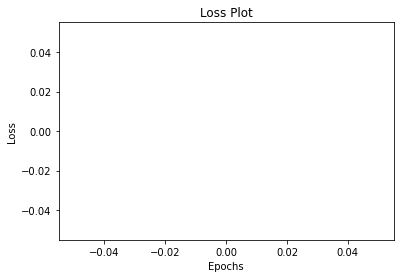

In [49]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate 

In [50]:
def predict_sentence(img_val, idx):

    image = img_val[idx]
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [51]:
def get_real_caption(cap_val, idx):
    return [tokenizer.index_word[i] for i in cap_val[idx] if i not in [0]]

In [52]:
def get_bleu(reference, candidate):
    return sentence_bleu(reference, candidate)

In [53]:
def evaluate_one_pair(img_val, cap_val, idx, show_pair=True):

    pred_sentence = predict_sentence(img_val, idx)
    real_sentence = get_real_caption(cap_val, idx)

    if '<end>' in pred_sentence:
        pred_sentence.remove('<end>')
    real_sentence.remove('<start>')
    real_sentence.remove('<end>')

    if show_pair:
        print('Predicted caption:', ' '.join(pred_sentence))
        print('Real caption:', ' '.join(real_sentence))

    return get_bleu(real_sentence, pred_sentence)

In [54]:
len(img_name_val), len(cap_val)

(19681, 19681)

In [57]:
def get_bleu_array(img_val, cap_val, cal_length=None):
    error_count = 0
    bleu_list = []
    if cal_length is None:
        val_len = range(len(img_name_val))
    else:
        val_len = range(cal_length)
    for i in progress_bar(val_len):
        try:
            bleu_score = evaluate_one_pair(img_name_val, cap_val, i, show_pair=False)
            bleu_list.append(bleu_score)
        except KeyError:
            print(i)
            error_count += 1
    return np.array(bleu_list), error_count

In [58]:
bleu_arr, error_count = get_bleu_array(img_name_val, cap_val, cal_length=2000)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


1169


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [59]:
np.mean(bleu_arr)

0.20722727713652367

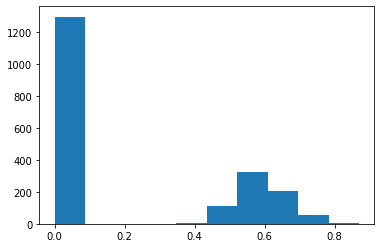

In [61]:
plt.hist(bleu_arr)
plt.show()

## Caption!

### Useful Functions

In [62]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [63]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Make Captions

In [64]:
rand_l = np.random.choice([*range(2000)], size=20, replace=False)
rand_l

array([ 775, 1648, 1993,   54, 1361,  442,  922, 1631,  928,  753, 1528,
       1374,  348, 1591,  335, 1758,  184,  521,  900, 1224])

In [65]:
for i in rand_l:
    pred = ' '.join(predict_sentence(img_name_val, i))
    print(i, pred)

775 what do we say to <unk> <unk> not today! <end>
1648 buy all the <unk> for very become <unk> <end>
1993 through k im <unk> are you a lot of the work <end>
54 <unk> of course for <unk> piss <end>
1361 enters <unk> spot you accidentally killed by stupid <unk> still think told the dear boy is <unk> <end>
442 i don't always downloaded them to get more <end>
922 <unk> <unk> <unk> <end>
1631 go against all my pussy <end>
928 what do we say to school not today! <end>
753 sees <unk> art of <unk> before you've probably <unk> <end>
1528 <unk> gets <unk> <end>
1374 you try to toilet break world <unk> dolls <end>
348 hey girl want to pull that word in the day i believe in you <end>
1591 sing i mouth drunk <end>
335 hey girl i used to make sure your cell phone <end>
1758 if you are over there <end>
184 this is this but i really need to paint your opinion in that day <end>
521 <unk> may i please tell me mission was at burger king <end>
900 what do we say to the god jokes not today! <end>
1224 i j

In [66]:
' '.join(get_real_caption(cap_val, 1865))

'<start> greg lake <end>'

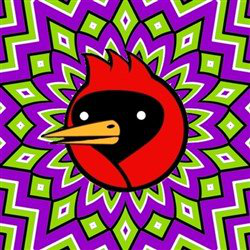

In [67]:
Image.open(img_name_val[1865])

Real Caption: <start> come at me bro! <end>
Prediction Caption: right now who needs more attention do <unk> over here <end>


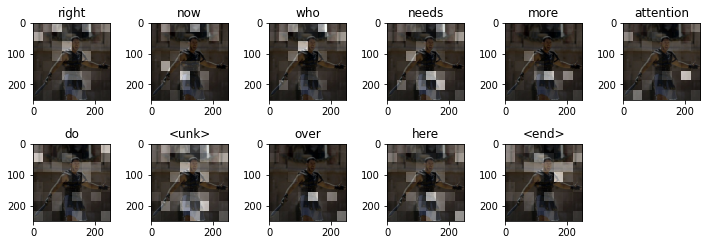

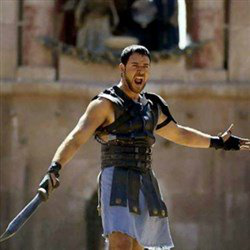

In [68]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [69]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = keras.utils.get_file('image'+image_extension, origin=image_url)

65536/64400 [==============================] - 0s 1us/step


In [70]:
#image_path = 'adam.png'

Prediction Caption: and mom is the sun breaks bones <end>


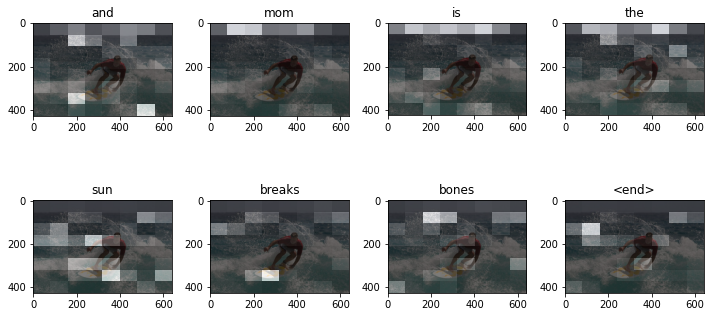

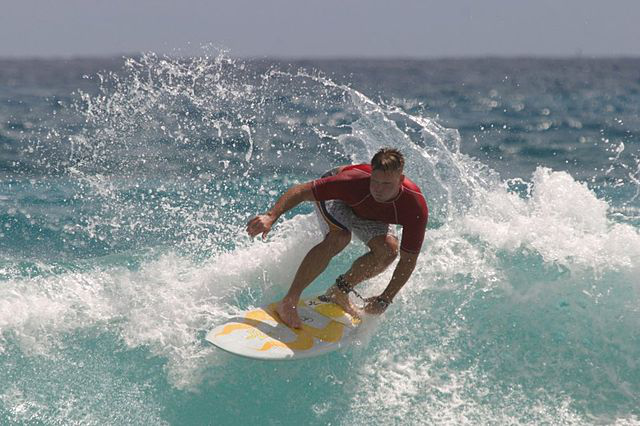

In [71]:
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)